# Classificatore Multi-Dimensionale di Email per Sinistri Medical Malpractice

Questo notebook illustra la creazione di un classificatore **multi-output** che distingue simultaneamente:

## Dimensione 1 - Tipologia:
- **Sinistro Avvenuto** (0): Incidente medico già verificato con danni concreti
- **Circostanza Potenziale** (1): Situazione che potrebbe generare un sinistro futuro

## Dimensione 2 - Riferimento Temporale:
- **Fatto Iniziale** (0): Prima segnalazione del caso
- **Follow-up** (1): Aggiornamento, integrazione documentale, evoluzione del caso

Utilizzeremo modelli di machine learning capaci di gestire classificazione multi-output.

## 1. Importazione Librerie

Importiamo tutte le librerie necessarie per l'analisi, preprocessing, training e visualizzazione multi-output.

In [1]:
# Librerie standard
import sys
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Preprocessing e feature engineering
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputClassifier

# Modelli di classificazione
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metriche e valutazione
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    roc_auc_score,
    hamming_loss,
    jaccard_score
)

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Configurazione visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerie importate con successo")
print("📊 Configurato per classificazione multi-output")

✅ Librerie importate con successo
📊 Configurato per classificazione multi-output


## 2. Caricamento Dataset Multi-Dimensionale

Carichiamo il dataset espanso di 1000 email con classificazione su due dimensioni indipendenti.

In [2]:
# Importa il modulo con il dataset mock
from mock_email_multidimensional_dataset import (
    create_mock_dataset, 
    get_category_names, 
    get_combined_category_name,
    get_dataset_statistics
)

# Carica il dataset
df = create_mock_dataset()
category_names = get_category_names()
stats = get_dataset_statistics(df)

# Visualizza informazioni base
print(f"📊 DATASET CARICATO\n")
print(f"{'='*80}")
print(f"Totale email: {stats['totale_email']}")
print(f"\n📋 DISTRIBUZIONE PER TIPOLOGIA:")
print(f"  • Sinistri Avvenuti: {stats['per_tipologia']['sinistri_avvenuti']}")
print(f"  • Circostanze Potenziali: {stats['per_tipologia']['circostanze_potenziali']}")
print(f"\n⏰ DISTRIBUZIONE PER RIFERIMENTO TEMPORALE:")
print(f"  • Fatti Iniziali: {stats['per_riferimento']['fatti_iniziali']}")
print(f"  • Follow-up: {stats['per_riferimento']['followup']}")
print(f"\n🔀 DISTRIBUZIONE PER COMBINAZIONE:")
for key, value in stats['per_combinazione'].items():
    print(f"  • {key.replace('_', ' ').title()}: {value}")
print(f"{'='*80}\n")

# Visualizza nomi categorie
print("📝 CATEGORIE:")
print(f"\nDimensione 1 - Tipologia:")
for cat_id, cat_name in category_names['tipologia'].items():
    print(f"  {cat_id}: {cat_name}")
print(f"\nDimensione 2 - Riferimento Temporale:")
for cat_id, cat_name in category_names['riferimento_temporale'].items():
    print(f"  {cat_id}: {cat_name}")

📊 DATASET CARICATO

Totale email: 999

📋 DISTRIBUZIONE PER TIPOLOGIA:
  • Sinistri Avvenuti: 500
  • Circostanze Potenziali: 499

⏰ DISTRIBUZIONE PER RIFERIMENTO TEMPORALE:
  • Fatti Iniziali: 499
  • Follow-up: 500

🔀 DISTRIBUZIONE PER COMBINAZIONE:
  • Sinistro Iniziale: 250
  • Sinistro Followup: 250
  • Circostanza Iniziale: 249
  • Circostanza Followup: 250

📝 CATEGORIE:

Dimensione 1 - Tipologia:
  0: Sinistro Avvenuto
  1: Circostanza Potenziale

Dimensione 2 - Riferimento Temporale:
  0: Fatto Iniziale
  1: Follow-up


## 3. Esplorazione dei Dati Multi-Dimensionali

Visualizziamo esempi per ogni combinazione delle due dimensioni.

In [3]:
# Visualizza 2 esempi per ogni combinazione
print("📧 ESEMPI DI EMAIL PER COMBINAZIONE\n")

combinations = [
    (0, 0, "Sinistro Avvenuto - Fatto Iniziale"),
    (0, 1, "Sinistro Avvenuto - Follow-up"),
    (1, 0, "Circostanza Potenziale - Fatto Iniziale"),
    (1, 1, "Circostanza Potenziale - Follow-up")
]

for tip, rif, label in combinations:
    print(f"\n{'='*80}")
    print(f"{label.upper()}")
    print(f"{'='*80}\n")
    
    mask = (df['tipologia'] == tip) & (df['riferimento_temporale'] == rif)
    esempi = df[mask].head(2)
    
    for idx, (i, row) in enumerate(esempi.iterrows(), 1):
        print(f"Esempio {idx}:")
        print(f"{row['testo'][:200]}...")
        print(f"\n{'-'*80}\n")

📧 ESEMPI DI EMAIL PER COMBINAZIONE


SINISTRO AVVENUTO - FATTO INIZIALE

Esempio 1:
Oggetto: Sinistro medico 25/11/2024. Durante procedura diagnostica si è verificato danno iatrogeno con conseguenze permanenti per il paziente....

--------------------------------------------------------------------------------

Esempio 2:
Segnalo grave errore medico avvenuto il 28/12/2024. Necessito aprire immediatamente pratica assicurativa per i danni subiti da mio familiare....

--------------------------------------------------------------------------------


SINISTRO AVVENUTO - FOLLOW-UP

Esempio 1:
Rif. pratica SIN28913: invio ulteriore documentazione richiesta dal perito assicurativo. Allego referto aggiornato sulle condizioni cliniche attuali....

--------------------------------------------------------------------------------

Esempio 2:
In merito al sinistro SIN96267, comunico peggioramento quadro clinico. Necessario aggiornare la valutazione del danno permanente....

------------------------

## 4. Analisi Statistica del Testo Multi-Dimensionale

Analizziamo le caratteristiche testuali per identificare pattern distintivi tra le categorie su entrambe le dimensioni.

📈 STATISTICHE TESTUALI PER TIPOLOGIA

          lunghezza_testo                  numero_parole              
                     mean    std  min  max          mean   std min max
tipologia                                                             
0                  143.33  15.39  113  229         18.01  3.05  13  31
1                  139.33   9.35  125  186         18.23  2.53  14  29

📈 STATISTICHE TESTUALI PER RIFERIMENTO TEMPORALE

                      lunghezza_testo                  numero_parole        \
                                 mean    std  min  max          mean   std   
riferimento_temporale                                                        
0                              144.08  10.74  127  229         19.19  2.42   
1                              138.59  14.21  113  204         17.05  2.76   

                               
                      min max  
riferimento_temporale          
0                      16  31  
1                      13  29  


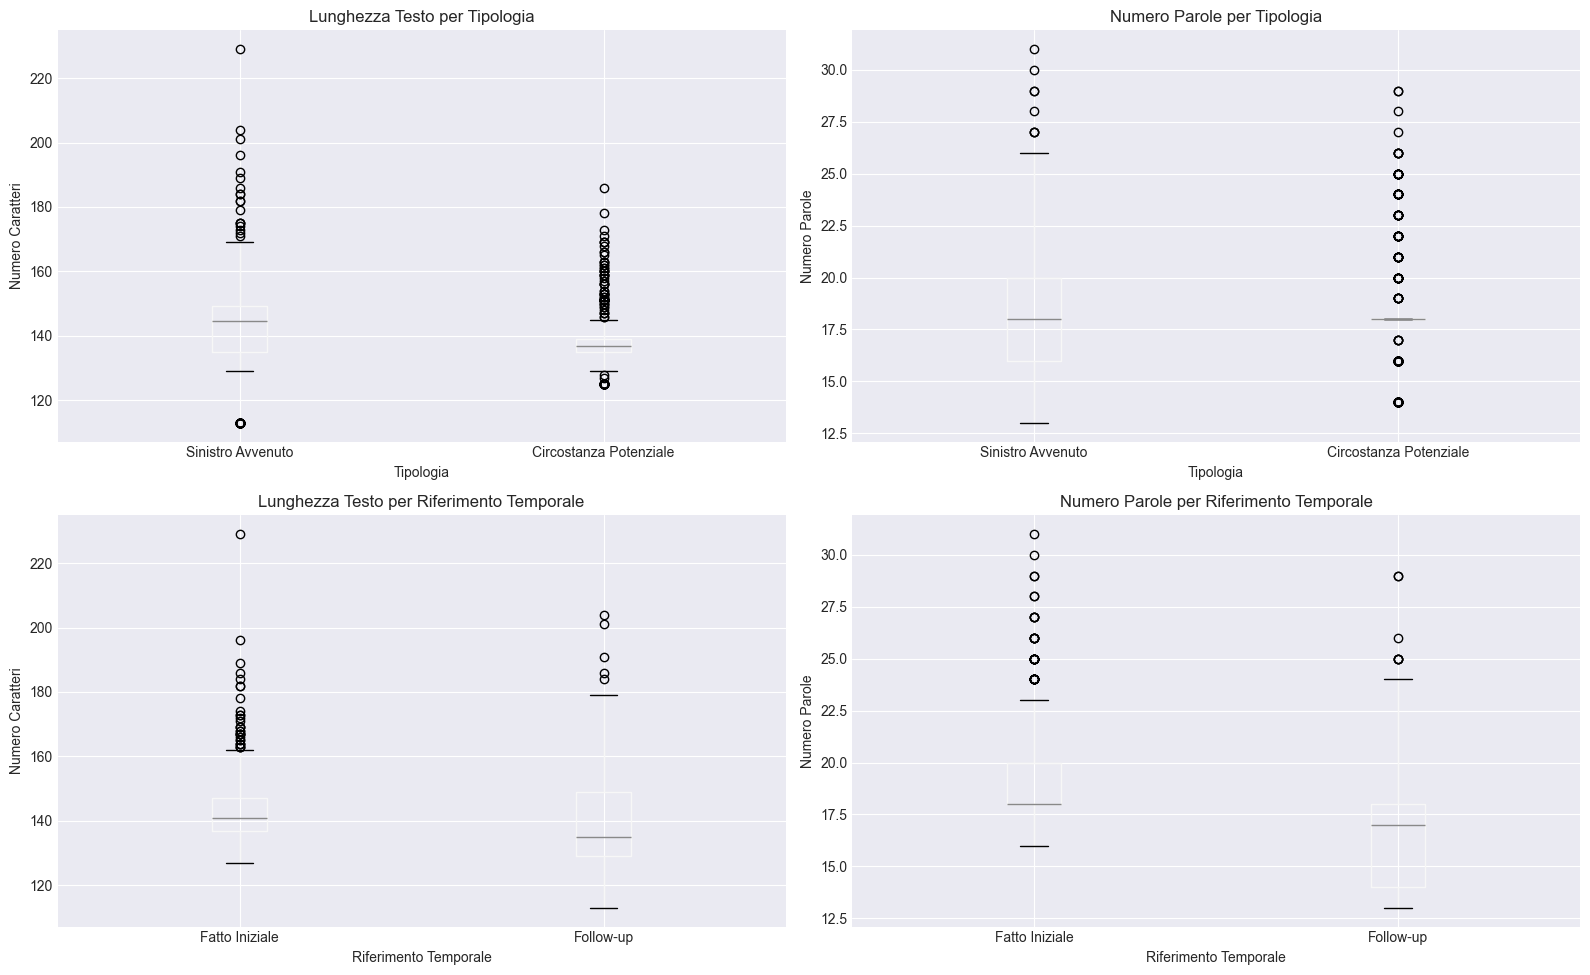

In [4]:
# Calcola statistiche testuali
df['lunghezza_testo'] = df['testo'].apply(len)
df['numero_parole'] = df['testo'].apply(lambda x: len(x.split()))

# Statistiche per tipologia
print("📈 STATISTICHE TESTUALI PER TIPOLOGIA\n")
stats_tipologia = df.groupby('tipologia').agg({
    'lunghezza_testo': ['mean', 'std', 'min', 'max'],
    'numero_parole': ['mean', 'std', 'min', 'max']
}).round(2)
print(stats_tipologia)

# Statistiche per riferimento temporale
print("\n📈 STATISTICHE TESTUALI PER RIFERIMENTO TEMPORALE\n")
stats_riferimento = df.groupby('riferimento_temporale').agg({
    'lunghezza_testo': ['mean', 'std', 'min', 'max'],
    'numero_parole': ['mean', 'std', 'min', 'max']
}).round(2)
print(stats_riferimento)

# Visualizzazione grafica - 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Boxplot lunghezza testo per tipologia
df.boxplot(column='lunghezza_testo', by='tipologia', ax=axes[0, 0])
axes[0, 0].set_title('Lunghezza Testo per Tipologia')
axes[0, 0].set_xlabel('Tipologia')
axes[0, 0].set_ylabel('Numero Caratteri')
axes[0, 0].set_xticklabels([category_names['tipologia'][0], category_names['tipologia'][1]])

# Boxplot numero parole per tipologia
df.boxplot(column='numero_parole', by='tipologia', ax=axes[0, 1])
axes[0, 1].set_title('Numero Parole per Tipologia')
axes[0, 1].set_xlabel('Tipologia')
axes[0, 1].set_ylabel('Numero Parole')
axes[0, 1].set_xticklabels([category_names['tipologia'][0], category_names['tipologia'][1]])

# Boxplot lunghezza testo per riferimento temporale
df.boxplot(column='lunghezza_testo', by='riferimento_temporale', ax=axes[1, 0])
axes[1, 0].set_title('Lunghezza Testo per Riferimento Temporale')
axes[1, 0].set_xlabel('Riferimento Temporale')
axes[1, 0].set_ylabel('Numero Caratteri')
axes[1, 0].set_xticklabels([category_names['riferimento_temporale'][0], 
                            category_names['riferimento_temporale'][1]])

# Boxplot numero parole per riferimento temporale
df.boxplot(column='numero_parole', by='riferimento_temporale', ax=axes[1, 1])
axes[1, 1].set_title('Numero Parole per Riferimento Temporale')
axes[1, 1].set_xlabel('Riferimento Temporale')
axes[1, 1].set_ylabel('Numero Parole')
axes[1, 1].set_xticklabels([category_names['riferimento_temporale'][0], 
                            category_names['riferimento_temporale'][1]])

plt.suptitle('')
plt.tight_layout()
plt.show()

## 5. Preparazione dei Dati Multi-Output

Separiamo i dati in training set (80%) e test set (20%). Creiamo target multi-output con entrambe le dimensioni.

In [5]:
# Separazione features (X) e target multi-output (y)
X = df['testo']

# Crea matrice target multi-output (N x 2)
# Colonna 0: tipologia, Colonna 1: riferimento_temporale
y_multi = df[['tipologia', 'riferimento_temporale']].values

# Per stratificazione, creiamo una label combinata temporanea
df['combined_label'] = df['tipologia'].astype(str) + '_' + df['riferimento_temporale'].astype(str)

# Split train/test con stratificazione
X_train, X_test, y_train_multi, y_test_multi = train_test_split(
    X, y_multi,
    test_size=0.2, 
    random_state=42, 
    stratify=df['combined_label']
)

# Separa le due dimensioni per analisi
y_train_tipologia = y_train_multi[:, 0]
y_train_riferimento = y_train_multi[:, 1]
y_test_tipologia = y_test_multi[:, 0]
y_test_riferimento = y_test_multi[:, 1]

print(f"✂️ SPLIT DEI DATI MULTI-OUTPUT\n")
print(f"{'='*80}")
print(f"Training set: {len(X_train)} email ({len(X_train)/len(df)*100:.1f}%)")
print(f"Test set: {len(X_test)} email ({len(X_test)/len(df)*100:.1f}%)")

print(f"\n📊 DISTRIBUZIONE TRAINING SET:")
print(f"\nDimensione 1 - Tipologia:")
unique, counts = np.unique(y_train_tipologia, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  {category_names['tipologia'][val]}: {count}")

print(f"\nDimensione 2 - Riferimento Temporale:")
unique, counts = np.unique(y_train_riferimento, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  {category_names['riferimento_temporale'][val]}: {count}")

print(f"\n📊 DISTRIBUZIONE TEST SET:")
print(f"\nDimensione 1 - Tipologia:")
unique, counts = np.unique(y_test_tipologia, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  {category_names['tipologia'][val]}: {count}")

print(f"\nDimensione 2 - Riferimento Temporale:")
unique, counts = np.unique(y_test_riferimento, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  {category_names['riferimento_temporale'][val]}: {count}")

print(f"{'='*80}")

✂️ SPLIT DEI DATI MULTI-OUTPUT

Training set: 799 email (80.0%)
Test set: 200 email (20.0%)

📊 DISTRIBUZIONE TRAINING SET:

Dimensione 1 - Tipologia:
  Sinistro Avvenuto: 400
  Circostanza Potenziale: 399

Dimensione 2 - Riferimento Temporale:
  Fatto Iniziale: 399
  Follow-up: 400

📊 DISTRIBUZIONE TEST SET:

Dimensione 1 - Tipologia:
  Sinistro Avvenuto: 100
  Circostanza Potenziale: 100

Dimensione 2 - Riferimento Temporale:
  Fatto Iniziale: 100
  Follow-up: 100


## 6. Feature Engineering - TF-IDF Vectorization

Trasformiamo il testo in vettori numerici usando TF-IDF (Term Frequency-Inverse Document Frequency).

In [6]:
# Configurazione del vectorizer TF-IDF
vectorizer = TfidfVectorizer(
    max_features=1000,       # Aumentato per dataset più grande
    ngram_range=(1, 2),      # Usa unigrammi e bigrammi
    min_df=3,                # Parola deve apparire in almeno 3 documenti
    max_df=0.8,              # Ignora parole in più dell'80% dei documenti
    strip_accents='unicode', # Rimuove accenti
    lowercase=True           # Converte tutto in minuscolo
)

# Fit del vectorizer sul training set
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"🔢 VETTORIZZAZIONE TF-IDF COMPLETATA\n")
print(f"{'='*80}")
print(f"Forma matrice training: {X_train_tfidf.shape}")
print(f"Forma matrice test: {X_test_tfidf.shape}")
print(f"Numero di features (parole): {len(vectorizer.get_feature_names_out())}")
sparsity = (1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))*100
print(f"Sparsità matrice: {sparsity:.2f}%")
print(f"{'='*80}")

🔢 VETTORIZZAZIONE TF-IDF COMPLETATA

Forma matrice training: (799, 715)
Forma matrice test: (200, 715)
Numero di features (parole): 715
Sparsità matrice: 95.94%


## 7. Training Modelli Multi-Output - Naive Bayes

Naive Bayes con MultiOutputClassifier per gestire entrambe le dimensioni simultaneamente.

In [7]:
# Inizializzazione modello multi-output Naive Bayes
nb_base = MultinomialNB(alpha=1.0)
nb_multi_model = MultiOutputClassifier(nb_base)

# Training
print("🏋️ Training Naive Bayes Multi-Output...")
nb_multi_model.fit(X_train_tfidf, y_train_multi)

# Predizioni
y_pred_nb_multi = nb_multi_model.predict(X_test_tfidf)
y_pred_nb_tipologia = y_pred_nb_multi[:, 0]
y_pred_nb_riferimento = y_pred_nb_multi[:, 1]

# Calcolo metriche per dimensione 1 - Tipologia
nb_acc_tip = accuracy_score(y_test_tipologia, y_pred_nb_tipologia)
nb_prec_tip, nb_rec_tip, nb_f1_tip, _ = precision_recall_fscore_support(
    y_test_tipologia, y_pred_nb_tipologia, average='weighted'
)

# Calcolo metriche per dimensione 2 - Riferimento Temporale
nb_acc_rif = accuracy_score(y_test_riferimento, y_pred_nb_riferimento)
nb_prec_rif, nb_rec_rif, nb_f1_rif, _ = precision_recall_fscore_support(
    y_test_riferimento, y_pred_nb_riferimento, average='weighted'
)

# Metriche multi-output aggregate
nb_hamming = hamming_loss(y_test_multi, y_pred_nb_multi)
nb_jaccard = jaccard_score(y_test_multi, y_pred_nb_multi, average='samples')
nb_exact_match = np.mean(np.all(y_pred_nb_multi == y_test_multi, axis=1))

print(f"\n🤖 MODELLO 1: NAIVE BAYES MULTI-OUTPUT\n")
print(f"{'='*80}")
print(f"\n📊 DIMENSIONE 1 - TIPOLOGIA:")
print(f"  Accuracy:  {nb_acc_tip:.4f}")
print(f"  Precision: {nb_prec_tip:.4f}")
print(f"  Recall:    {nb_rec_tip:.4f}")
print(f"  F1-Score:  {nb_f1_tip:.4f}")

print(f"\n📊 DIMENSIONE 2 - RIFERIMENTO TEMPORALE:")
print(f"  Accuracy:  {nb_acc_rif:.4f}")
print(f"  Precision: {nb_prec_rif:.4f}")
print(f"  Recall:    {nb_rec_rif:.4f}")
print(f"  F1-Score:  {nb_f1_rif:.4f}")

print(f"\n🎯 METRICHE MULTI-OUTPUT:")
print(f"  Hamming Loss:      {nb_hamming:.4f} (più basso è meglio)")
print(f"  Jaccard Score:     {nb_jaccard:.4f}")
print(f"  Exact Match Ratio: {nb_exact_match:.4f} (tutte le dimensioni corrette)")
print(f"{'='*80}")

🏋️ Training Naive Bayes Multi-Output...

🤖 MODELLO 1: NAIVE BAYES MULTI-OUTPUT


📊 DIMENSIONE 1 - TIPOLOGIA:
  Accuracy:  0.9950
  Precision: 0.9950
  Recall:    0.9950
  F1-Score:  0.9950

📊 DIMENSIONE 2 - RIFERIMENTO TEMPORALE:
  Accuracy:  0.9950
  Precision: 0.9950
  Recall:    0.9950
  F1-Score:  0.9950

🎯 METRICHE MULTI-OUTPUT:
  Hamming Loss:      0.0050 (più basso è meglio)
  Jaccard Score:     0.7450
  Exact Match Ratio: 0.9900 (tutte le dimensioni corrette)


## 8. Training Modelli Multi-Output - Logistic Regression

Logistic Regression con MultiOutputClassifier per entrambe le dimensioni.

In [8]:
# Inizializzazione modello multi-output Logistic Regression
lr_base = LogisticRegression(max_iter=1000, C=1.0, random_state=42, solver='lbfgs')
lr_multi_model = MultiOutputClassifier(lr_base)

# Training
print("🏋️ Training Logistic Regression Multi-Output...")
lr_multi_model.fit(X_train_tfidf, y_train_multi)

# Predizioni
y_pred_lr_multi = lr_multi_model.predict(X_test_tfidf)
y_pred_lr_tipologia = y_pred_lr_multi[:, 0]
y_pred_lr_riferimento = y_pred_lr_multi[:, 1]

# Calcolo metriche per dimensione 1 - Tipologia
lr_acc_tip = accuracy_score(y_test_tipologia, y_pred_lr_tipologia)
lr_prec_tip, lr_rec_tip, lr_f1_tip, _ = precision_recall_fscore_support(
    y_test_tipologia, y_pred_lr_tipologia, average='weighted'
)

# Calcolo metriche per dimensione 2 - Riferimento Temporale
lr_acc_rif = accuracy_score(y_test_riferimento, y_pred_lr_riferimento)
lr_prec_rif, lr_rec_rif, lr_f1_rif, _ = precision_recall_fscore_support(
    y_test_riferimento, y_pred_lr_riferimento, average='weighted'
)

# Metriche multi-output aggregate
lr_hamming = hamming_loss(y_test_multi, y_pred_lr_multi)
lr_jaccard = jaccard_score(y_test_multi, y_pred_lr_multi, average='samples')
lr_exact_match = np.mean(np.all(y_pred_lr_multi == y_test_multi, axis=1))

print(f"\n🤖 MODELLO 2: LOGISTIC REGRESSION MULTI-OUTPUT\n")
print(f"{'='*80}")
print(f"\n📊 DIMENSIONE 1 - TIPOLOGIA:")
print(f"  Accuracy:  {lr_acc_tip:.4f}")
print(f"  Precision: {lr_prec_tip:.4f}")
print(f"  Recall:    {lr_rec_tip:.4f}")
print(f"  F1-Score:  {lr_f1_tip:.4f}")

print(f"\n📊 DIMENSIONE 2 - RIFERIMENTO TEMPORALE:")
print(f"  Accuracy:  {lr_acc_rif:.4f}")
print(f"  Precision: {lr_prec_rif:.4f}")
print(f"  Recall:    {lr_rec_rif:.4f}")
print(f"  F1-Score:  {lr_f1_rif:.4f}")

print(f"\n🎯 METRICHE MULTI-OUTPUT:")
print(f"  Hamming Loss:      {lr_hamming:.4f}")
print(f"  Jaccard Score:     {lr_jaccard:.4f}")
print(f"  Exact Match Ratio: {lr_exact_match:.4f}")
print(f"{'='*80}")

🏋️ Training Logistic Regression Multi-Output...

🤖 MODELLO 2: LOGISTIC REGRESSION MULTI-OUTPUT


📊 DIMENSIONE 1 - TIPOLOGIA:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

📊 DIMENSIONE 2 - RIFERIMENTO TEMPORALE:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

🎯 METRICHE MULTI-OUTPUT:
  Hamming Loss:      0.0000
  Jaccard Score:     0.7500
  Exact Match Ratio: 1.0000


## 9. Training Modelli Multi-Output - Random Forest

Random Forest con MultiOutputClassifier per entrambe le dimensioni.

In [9]:
# Inizializzazione modello multi-output Random Forest
rf_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=30,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_multi_model = MultiOutputClassifier(rf_base)

# Training
print("🏋️ Training Random Forest Multi-Output...")
rf_multi_model.fit(X_train_tfidf, y_train_multi)

# Predizioni
y_pred_rf_multi = rf_multi_model.predict(X_test_tfidf)
y_pred_rf_tipologia = y_pred_rf_multi[:, 0]
y_pred_rf_riferimento = y_pred_rf_multi[:, 1]

# Calcolo metriche per dimensione 1 - Tipologia
rf_acc_tip = accuracy_score(y_test_tipologia, y_pred_rf_tipologia)
rf_prec_tip, rf_rec_tip, rf_f1_tip, _ = precision_recall_fscore_support(
    y_test_tipologia, y_pred_rf_tipologia, average='weighted'
)

# Calcolo metriche per dimensione 2 - Riferimento Temporale
rf_acc_rif = accuracy_score(y_test_riferimento, y_pred_rf_riferimento)
rf_prec_rif, rf_rec_rif, rf_f1_rif, _ = precision_recall_fscore_support(
    y_test_riferimento, y_pred_rf_riferimento, average='weighted'
)

# Metriche multi-output aggregate
rf_hamming = hamming_loss(y_test_multi, y_pred_rf_multi)
rf_jaccard = jaccard_score(y_test_multi, y_pred_rf_multi, average='samples')
rf_exact_match = np.mean(np.all(y_pred_rf_multi == y_test_multi, axis=1))

print(f"\n🤖 MODELLO 3: RANDOM FOREST MULTI-OUTPUT\n")
print(f"{'='*80}")
print(f"\n📊 DIMENSIONE 1 - TIPOLOGIA:")
print(f"  Accuracy:  {rf_acc_tip:.4f}")
print(f"  Precision: {rf_prec_tip:.4f}")
print(f"  Recall:    {rf_rec_tip:.4f}")
print(f"  F1-Score:  {rf_f1_tip:.4f}")

print(f"\n📊 DIMENSIONE 2 - RIFERIMENTO TEMPORALE:")
print(f"  Accuracy:  {rf_acc_rif:.4f}")
print(f"  Precision: {rf_prec_rif:.4f}")
print(f"  Recall:    {rf_rec_rif:.4f}")
print(f"  F1-Score:  {rf_f1_rif:.4f}")

print(f"\n🎯 METRICHE MULTI-OUTPUT:")
print(f"  Hamming Loss:      {rf_hamming:.4f}")
print(f"  Jaccard Score:     {rf_jaccard:.4f}")
print(f"  Exact Match Ratio: {rf_exact_match:.4f}")
print(f"{'='*80}")

🏋️ Training Random Forest Multi-Output...

🤖 MODELLO 3: RANDOM FOREST MULTI-OUTPUT


📊 DIMENSIONE 1 - TIPOLOGIA:
  Accuracy:  0.9950
  Precision: 0.9950
  Recall:    0.9950
  F1-Score:  0.9950

📊 DIMENSIONE 2 - RIFERIMENTO TEMPORALE:
  Accuracy:  0.9950
  Precision: 0.9950
  Recall:    0.9950
  F1-Score:  0.9950

🎯 METRICHE MULTI-OUTPUT:
  Hamming Loss:      0.0050
  Jaccard Score:     0.7475
  Exact Match Ratio: 0.9900


## 10. Confronto Performance Modelli Multi-Output

Confrontiamo le performance dei tre modelli su entrambe le dimensioni e sulle metriche aggregate.

📊 CONFRONTO COMPLETO MODELLI MULTI-OUTPUT

            Modello  Acc_Tipologia  F1_Tipologia  Acc_Riferimento  F1_Riferimento  Hamming_Loss  Jaccard_Score  Exact_Match
        Naive Bayes          0.995         0.995            0.995           0.995         0.005         0.7450         0.99
Logistic Regression          1.000         1.000            1.000           1.000         0.000         0.7500         1.00
      Random Forest          0.995         0.995            0.995           0.995         0.005         0.7475         0.99


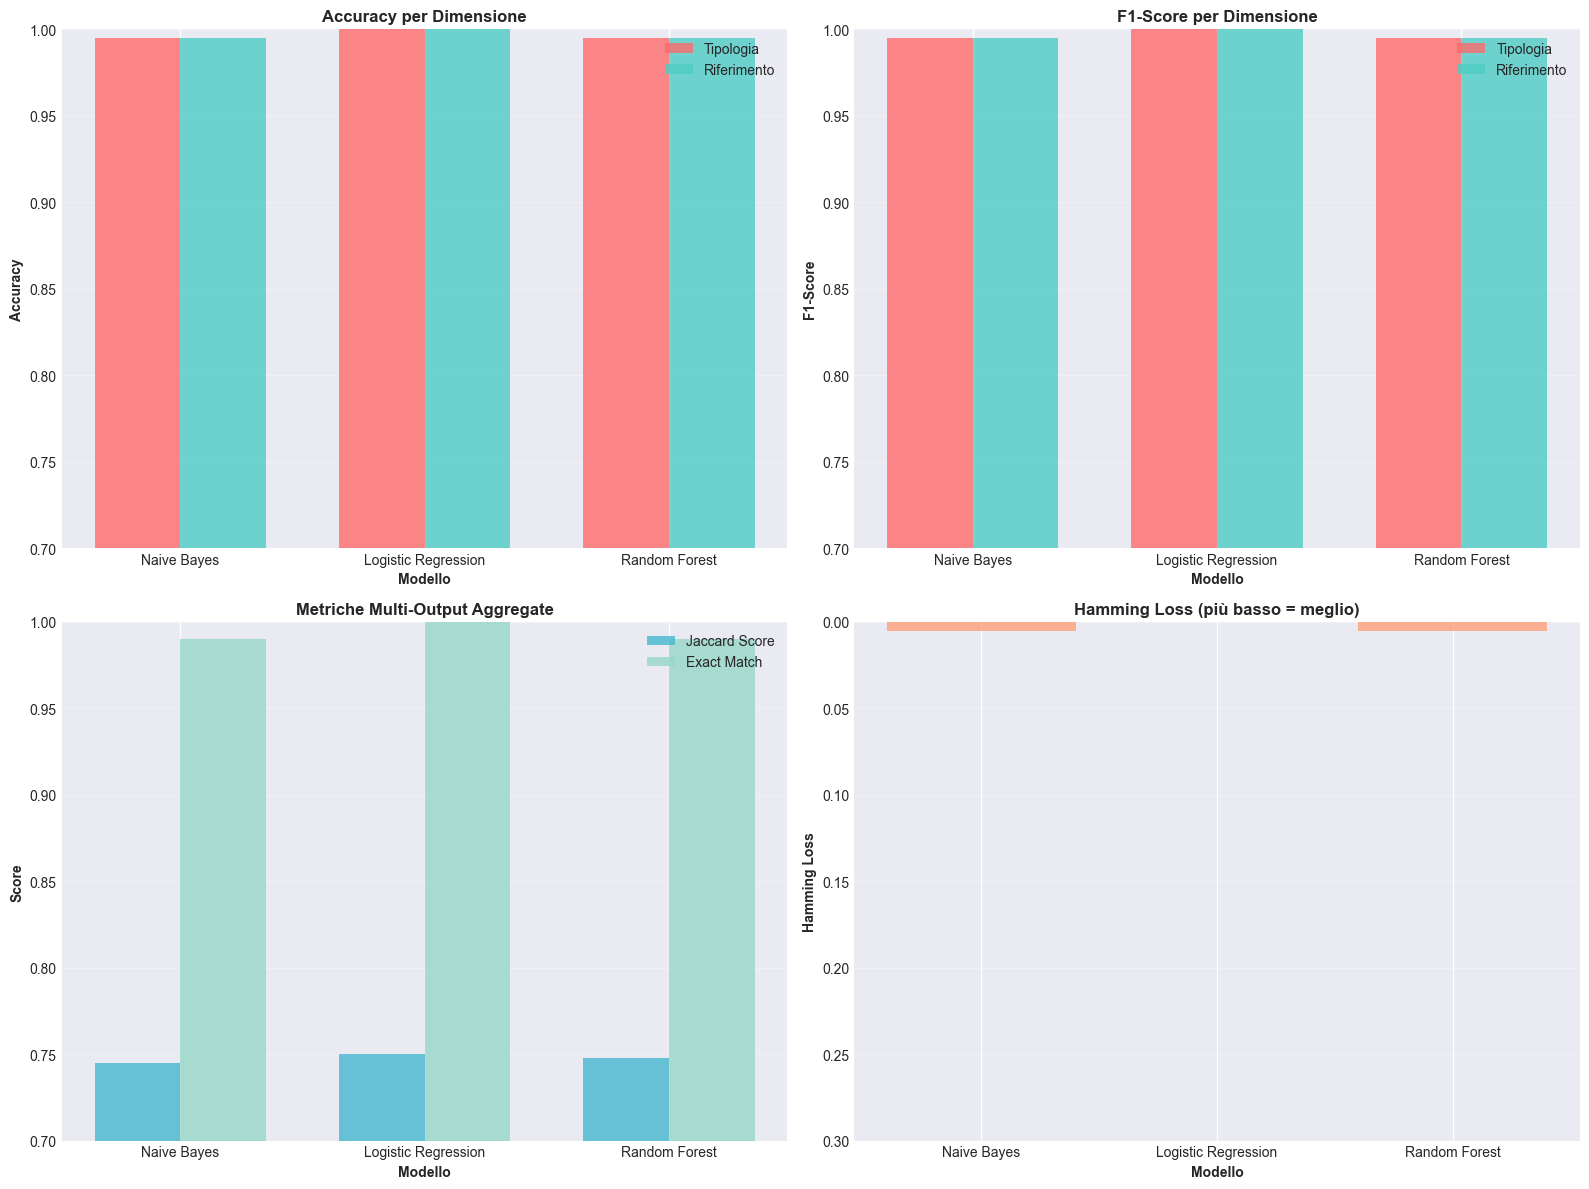


🏆 MIGLIORI MODELLI PER METRICA:

F1-Score Tipologia:     Logistic Regression
F1-Score Riferimento:   Logistic Regression
Exact Match Ratio:      Logistic Regression (1.0000)
Jaccard Score:          Logistic Regression (0.7500)


In [10]:
# Creazione DataFrame comparativo completo
comparison_multi_df = pd.DataFrame({
    'Modello': ['Naive Bayes', 'Logistic Regression', 'Random Forest'],
    
    # Dimensione 1 - Tipologia
    'Acc_Tipologia': [nb_acc_tip, lr_acc_tip, rf_acc_tip],
    'F1_Tipologia': [nb_f1_tip, lr_f1_tip, rf_f1_tip],
    
    # Dimensione 2 - Riferimento Temporale
    'Acc_Riferimento': [nb_acc_rif, lr_acc_rif, rf_acc_rif],
    'F1_Riferimento': [nb_f1_rif, lr_f1_rif, rf_f1_rif],
    
    # Metriche aggregate
    'Hamming_Loss': [nb_hamming, lr_hamming, rf_hamming],
    'Jaccard_Score': [nb_jaccard, lr_jaccard, rf_jaccard],
    'Exact_Match': [nb_exact_match, lr_exact_match, rf_exact_match]
})

print("📊 CONFRONTO COMPLETO MODELLI MULTI-OUTPUT\n")
print("="*80)
print(comparison_multi_df.to_string(index=False))
print("="*80)

# Visualizzazione grafica comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy per dimensione
ax1 = axes[0, 0]
x = np.arange(len(comparison_multi_df))
width = 0.35
bars1 = ax1.bar(x - width/2, comparison_multi_df['Acc_Tipologia'], 
                width, label='Tipologia', color='#FF6B6B', alpha=0.8)
bars2 = ax1.bar(x + width/2, comparison_multi_df['Acc_Riferimento'], 
                width, label='Riferimento', color='#4ECDC4', alpha=0.8)
ax1.set_xlabel('Modello', fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Accuracy per Dimensione', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_multi_df['Modello'])
ax1.legend()
ax1.set_ylim([0.7, 1.0])
ax1.grid(axis='y', alpha=0.3)

# 2. F1-Score per dimensione
ax2 = axes[0, 1]
bars3 = ax2.bar(x - width/2, comparison_multi_df['F1_Tipologia'], 
                width, label='Tipologia', color='#FF6B6B', alpha=0.8)
bars4 = ax2.bar(x + width/2, comparison_multi_df['F1_Riferimento'], 
                width, label='Riferimento', color='#4ECDC4', alpha=0.8)
ax2.set_xlabel('Modello', fontweight='bold')
ax2.set_ylabel('F1-Score', fontweight='bold')
ax2.set_title('F1-Score per Dimensione', fontweight='bold', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_multi_df['Modello'])
ax2.legend()
ax2.set_ylim([0.7, 1.0])
ax2.grid(axis='y', alpha=0.3)

# 3. Metriche Multi-Output Aggregate
ax3 = axes[1, 0]
metrics_aggregate = ['Jaccard_Score', 'Exact_Match']
colors_agg = ['#45B7D1', '#98D8C8']
for i, (metric, color) in enumerate(zip(metrics_aggregate, colors_agg)):
    offset = width * (i - 0.5)
    ax3.bar(x + offset, comparison_multi_df[metric], width, 
            label=metric.replace('_', ' '), color=color, alpha=0.8)
ax3.set_xlabel('Modello', fontweight='bold')
ax3.set_ylabel('Score', fontweight='bold')
ax3.set_title('Metriche Multi-Output Aggregate', fontweight='bold', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(comparison_multi_df['Modello'])
ax3.legend()
ax3.set_ylim([0.7, 1.0])
ax3.grid(axis='y', alpha=0.3)

# 4. Hamming Loss (più basso è meglio)
ax4 = axes[1, 1]
bars5 = ax4.bar(x, comparison_multi_df['Hamming_Loss'], 
                color='#FFA07A', alpha=0.8)
ax4.set_xlabel('Modello', fontweight='bold')
ax4.set_ylabel('Hamming Loss', fontweight='bold')
ax4.set_title('Hamming Loss (più basso = meglio)', fontweight='bold', fontsize=12)
ax4.set_xticks(x)
ax4.set_xticklabels(comparison_multi_df['Modello'])
ax4.set_ylim([0, 0.3])
ax4.grid(axis='y', alpha=0.3)
ax4.invert_yaxis()  # Inverti l'asse per enfatizzare "più basso è meglio"

plt.tight_layout()
plt.show()

# Identifica i modelli migliori per metrica
print("\n🏆 MIGLIORI MODELLI PER METRICA:\n")
best_tip_idx = comparison_multi_df['F1_Tipologia'].idxmax()
best_rif_idx = comparison_multi_df['F1_Riferimento'].idxmax()
best_exact_idx = comparison_multi_df['Exact_Match'].idxmax()
best_jaccard_idx = comparison_multi_df['Jaccard_Score'].idxmax()

print(f"F1-Score Tipologia:     {comparison_multi_df.loc[best_tip_idx, 'Modello']}")
print(f"F1-Score Riferimento:   {comparison_multi_df.loc[best_rif_idx, 'Modello']}")
print(f"Exact Match Ratio:      {comparison_multi_df.loc[best_exact_idx, 'Modello']} ({comparison_multi_df.loc[best_exact_idx, 'Exact_Match']:.4f})")
print(f"Jaccard Score:          {comparison_multi_df.loc[best_jaccard_idx, 'Modello']} ({comparison_multi_df.loc[best_jaccard_idx, 'Jaccard_Score']:.4f})")

## 11. Matrici di Confusione Multi-Dimensionali

Visualizziamo le matrici di confusione per entrambe le dimensioni per ciascun modello.

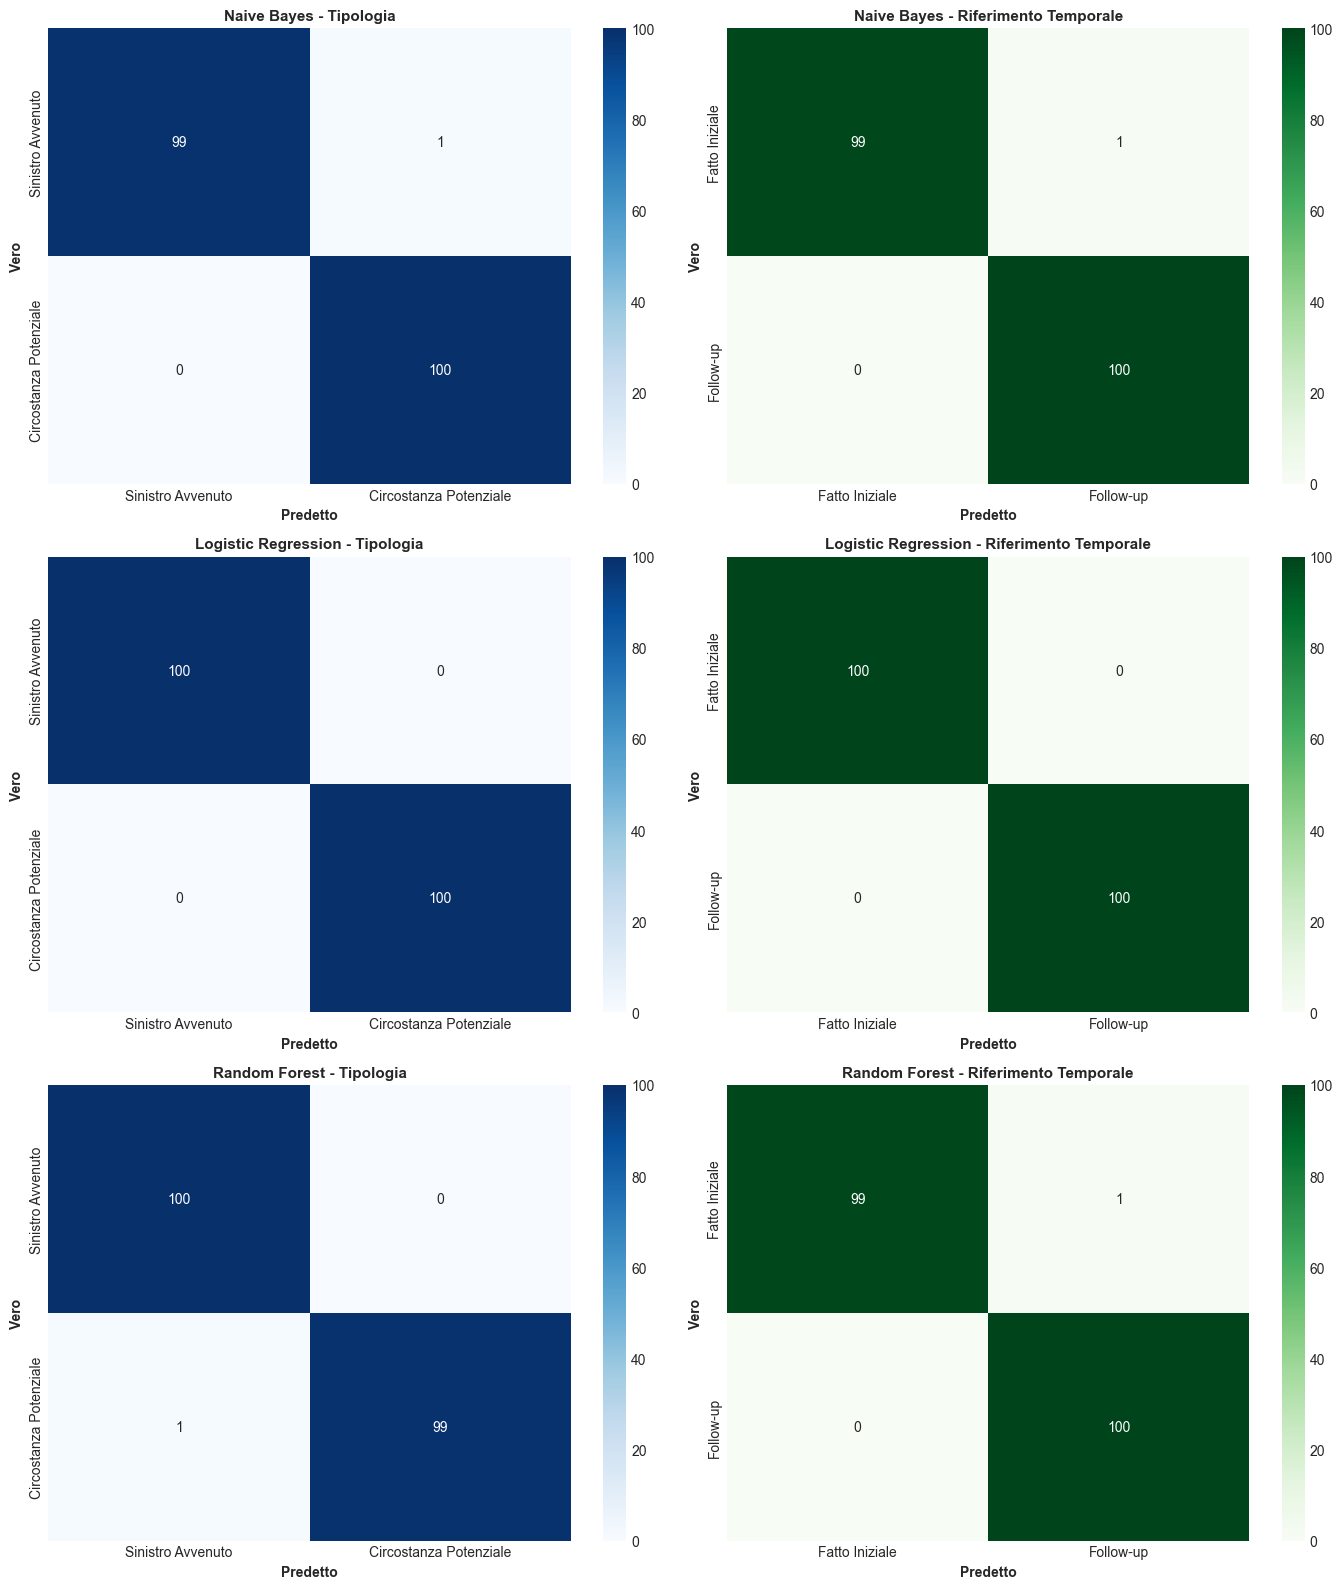


📋 DETTAGLIO ERRORI PER MODELLO E DIMENSIONE


NAIVE BAYES
--------------------------------------------------------------------------------

Dimensione 1 - Tipologia:
  True Negatives:    99 | False Positives:    1
  False Negatives:    0 | True Positives:   100
  Errori totali:      1 | Error rate: 0.50%

Dimensione 2 - Riferimento Temporale:
  True Negatives:    99 | False Positives:    1
  False Negatives:    0 | True Positives:   100
  Errori totali:      1 | Error rate: 0.50%
--------------------------------------------------------------------------------

LOGISTIC REGRESSION
--------------------------------------------------------------------------------

Dimensione 1 - Tipologia:
  True Negatives:   100 | False Positives:    0
  False Negatives:    0 | True Positives:   100
  Errori totali:      0 | Error rate: 0.00%

Dimensione 2 - Riferimento Temporale:
  True Negatives:   100 | False Positives:    0
  False Negatives:    0 | True Positives:   100
  Errori totali:      0 | Err

In [11]:
# Calcolo matrici di confusione per entrambe le dimensioni
models_data = [
    ('Naive Bayes', y_pred_nb_tipologia, y_pred_nb_riferimento),
    ('Logistic Regression', y_pred_lr_tipologia, y_pred_lr_riferimento),
    ('Random Forest', y_pred_rf_tipologia, y_pred_rf_riferimento)
]

# Visualizzazione 3x2 grid (3 modelli x 2 dimensioni)
fig, axes = plt.subplots(3, 2, figsize=(14, 16))

for idx, (model_name, pred_tip, pred_rif) in enumerate(models_data):
    # Confusion matrix per Tipologia
    cm_tip = confusion_matrix(y_test_tipologia, pred_tip)
    sns.heatmap(
        cm_tip, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        ax=axes[idx, 0],
        cbar=True,
        xticklabels=[category_names['tipologia'][0], category_names['tipologia'][1]],
        yticklabels=[category_names['tipologia'][0], category_names['tipologia'][1]]
    )
    axes[idx, 0].set_title(f'{model_name} - Tipologia', fontweight='bold', fontsize=11)
    axes[idx, 0].set_ylabel('Vero', fontweight='bold')
    axes[idx, 0].set_xlabel('Predetto', fontweight='bold')
    
    # Confusion matrix per Riferimento Temporale
    cm_rif = confusion_matrix(y_test_riferimento, pred_rif)
    sns.heatmap(
        cm_rif, 
        annot=True, 
        fmt='d', 
        cmap='Greens', 
        ax=axes[idx, 1],
        cbar=True,
        xticklabels=[category_names['riferimento_temporale'][0], 
                    category_names['riferimento_temporale'][1]],
        yticklabels=[category_names['riferimento_temporale'][0], 
                    category_names['riferimento_temporale'][1]]
    )
    axes[idx, 1].set_title(f'{model_name} - Riferimento Temporale', fontweight='bold', fontsize=11)
    axes[idx, 1].set_ylabel('Vero', fontweight='bold')
    axes[idx, 1].set_xlabel('Predetto', fontweight='bold')

plt.tight_layout()
plt.show()

# Statistiche dettagliate errori
print("\n📋 DETTAGLIO ERRORI PER MODELLO E DIMENSIONE\n")
print("="*80)
for model_name, pred_tip, pred_rif in models_data:
    print(f"\n{model_name.upper()}")
    print("-"*80)
    
    # Errori Tipologia
    cm_tip = confusion_matrix(y_test_tipologia, pred_tip)
    tn_tip, fp_tip, fn_tip, tp_tip = cm_tip.ravel()
    print(f"\nDimensione 1 - Tipologia:")
    print(f"  True Negatives:  {tn_tip:4d} | False Positives: {fp_tip:4d}")
    print(f"  False Negatives: {fn_tip:4d} | True Positives:  {tp_tip:4d}")
    print(f"  Errori totali:   {fp_tip + fn_tip:4d} | Error rate: {(fp_tip + fn_tip) / len(y_test_tipologia) * 100:.2f}%")
    
    # Errori Riferimento Temporale
    cm_rif = confusion_matrix(y_test_riferimento, pred_rif)
    tn_rif, fp_rif, fn_rif, tp_rif = cm_rif.ravel()
    print(f"\nDimensione 2 - Riferimento Temporale:")
    print(f"  True Negatives:  {tn_rif:4d} | False Positives: {fp_rif:4d}")
    print(f"  False Negatives: {fn_rif:4d} | True Positives:  {tp_rif:4d}")
    print(f"  Errori totali:   {fp_rif + fn_rif:4d} | Error rate: {(fp_rif + fn_rif) / len(y_test_riferimento) * 100:.2f}%")
    print("-"*80)

## 12. Classification Reports Multi-Dimensionali

Report dettagliati con precision, recall e f1-score per ciascuna classe su entrambe le dimensioni.

In [12]:
print("📈 CLASSIFICATION REPORTS MULTI-DIMENSIONALI\n")
print("="*80)

for model_name, pred_tip, pred_rif in models_data:
    print(f"\n{'='*80}")
    print(f"{model_name.upper()}")
    print(f"{'='*80}")
    
    print(f"\n📊 DIMENSIONE 1 - TIPOLOGIA\n{'-'*80}")
    report_tip = classification_report(
        y_test_tipologia, 
        pred_tip, 
        target_names=[category_names['tipologia'][0], category_names['tipologia'][1]],
        digits=4
    )
    print(report_tip)
    
    print(f"\n📊 DIMENSIONE 2 - RIFERIMENTO TEMPORALE\n{'-'*80}")
    report_rif = classification_report(
        y_test_riferimento, 
        pred_rif, 
        target_names=[category_names['riferimento_temporale'][0], 
                     category_names['riferimento_temporale'][1]],
        digits=4
    )
    print(report_rif)

📈 CLASSIFICATION REPORTS MULTI-DIMENSIONALI


NAIVE BAYES

📊 DIMENSIONE 1 - TIPOLOGIA
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

     Sinistro Avvenuto     1.0000    0.9900    0.9950       100
Circostanza Potenziale     0.9901    1.0000    0.9950       100

              accuracy                         0.9950       200
             macro avg     0.9950    0.9950    0.9950       200
          weighted avg     0.9950    0.9950    0.9950       200


📊 DIMENSIONE 2 - RIFERIMENTO TEMPORALE
--------------------------------------------------------------------------------
                precision    recall  f1-score   support

Fatto Iniziale     1.0000    0.9900    0.9950       100
     Follow-up     0.9901    1.0000    0.9950       100

      accuracy                         0.9950       200
     macro avg     0.9950    0.9950    0.9950       200
  weighted avg     0.9950    0.9950    0.99

## 13. Analisi Correlazione tra Dimensioni

Analizziamo se esiste correlazione tra gli errori delle due dimensioni.

🔍 ANALISI CORRELAZIONE ERRORI TRA DIMENSIONI


Naive Bayes:
--------------------------------------------------------------------------------
  Entrambe corrette:           198 (99.00%)
  Solo Tipologia errata:         1 ( 0.50%)
  Solo Riferimento errato:       1 ( 0.50%)
  Entrambe errate:               0 ( 0.00%)
  Correlazione errori:        -0.0050
--------------------------------------------------------------------------------

Logistic Regression:
--------------------------------------------------------------------------------
  Entrambe corrette:           200 (100.00%)
  Solo Tipologia errata:         0 ( 0.00%)
  Solo Riferimento errato:       0 ( 0.00%)
  Entrambe errate:               0 ( 0.00%)
  Correlazione errori:        nan
--------------------------------------------------------------------------------

Random Forest:
--------------------------------------------------------------------------------
  Entrambe corrette:           198 (99.00%)
  Solo Tipologia errata:    

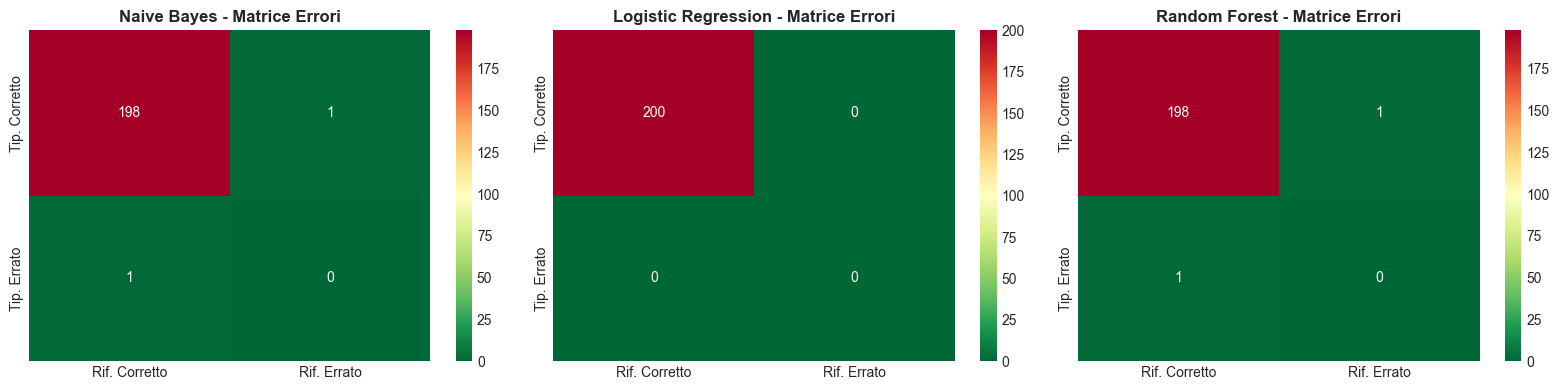

In [13]:
# Analisi errori correlati
print("🔍 ANALISI CORRELAZIONE ERRORI TRA DIMENSIONI\n")
print("="*80)

for model_name, pred_tip, pred_rif in models_data:
    print(f"\n{model_name}:")
    print("-"*80)
    
    # Identifica errori
    errors_tip = (y_test_tipologia != pred_tip)
    errors_rif = (y_test_riferimento != pred_rif)
    
    # Entrambe le dimensioni corrette
    both_correct = (~errors_tip) & (~errors_rif)
    
    # Solo tipologia errata
    only_tip_wrong = errors_tip & (~errors_rif)
    
    # Solo riferimento errato
    only_rif_wrong = (~errors_tip) & errors_rif
    
    # Entrambe errate
    both_wrong = errors_tip & errors_rif
    
    total = len(y_test_tipologia)
    
    print(f"  Entrambe corrette:          {np.sum(both_correct):4d} ({np.sum(both_correct)/total*100:5.2f}%)")
    print(f"  Solo Tipologia errata:      {np.sum(only_tip_wrong):4d} ({np.sum(only_tip_wrong)/total*100:5.2f}%)")
    print(f"  Solo Riferimento errato:    {np.sum(only_rif_wrong):4d} ({np.sum(only_rif_wrong)/total*100:5.2f}%)")
    print(f"  Entrambe errate:            {np.sum(both_wrong):4d} ({np.sum(both_wrong)/total*100:5.2f}%)")
    
    # Coefficiente di correlazione tra errori
    correlation = np.corrcoef(errors_tip.astype(int), errors_rif.astype(int))[0, 1]
    print(f"  Correlazione errori:        {correlation:.4f}")
    print("-"*80)

# Visualizzazione heatmap correlazione errori
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for idx, (model_name, pred_tip, pred_rif) in enumerate(models_data):
    errors_tip = (y_test_tipologia != pred_tip).astype(int)
    errors_rif = (y_test_riferimento != pred_rif).astype(int)
    
    # Crea matrice 2x2
    error_matrix = np.array([
        [np.sum((errors_tip == 0) & (errors_rif == 0)), np.sum((errors_tip == 0) & (errors_rif == 1))],
        [np.sum((errors_tip == 1) & (errors_rif == 0)), np.sum((errors_tip == 1) & (errors_rif == 1))]
    ])
    
    sns.heatmap(
        error_matrix,
        annot=True,
        fmt='d',
        cmap='RdYlGn_r',
        ax=axes[idx],
        cbar=True,
        xticklabels=['Rif. Corretto', 'Rif. Errato'],
        yticklabels=['Tip. Corretto', 'Tip. Errato']
    )
    axes[idx].set_title(f'{model_name} - Matrice Errori', fontweight='bold')

plt.tight_layout()
plt.show()

## 14. Test su Nuove Email Multi-Dimensionali

Testiamo i modelli su email nuove per verificare la capacità di predire entrambe le dimensioni.

In [14]:
# Email di test con etichette per entrambe le dimensioni
test_emails_multi = [
    {
        "testo": "Mio padre è morto il 5 maggio 2023 a causa di una trasfusione con gruppo sanguigno errato. Voglio avviare causa per risarcimento danni.",
        "tipologia_attesa": 0,  # Sinistro Avvenuto
        "riferimento_attesa": 0  # Fatto Iniziale
    },
    {
        "testo": "Rif. pratica SIN12345: invio aggiornamento documentazione medica richiesta. Allego referto specialistico che conferma nesso causale.",
        "tipologia_attesa": 0,  # Sinistro Avvenuto
        "riferimento_attesa": 1  # Follow-up
    },
    {
        "testo": "Sono preoccupato perché il medico non legge i risultati della biopsia da 10 giorni. Potrebbe essere un ritardo pericoloso?",
        "tipologia_attesa": 1,  # Circostanza Potenziale
        "riferimento_attesa": 0  # Fatto Iniziale
    },
    {
        "testo": "Con riferimento alla segnalazione 98765: aggiorno che la situazione persiste. Gli infermieri continuano a non rispettare le procedure.",
        "tipologia_attesa": 1,  # Circostanza Potenziale
        "riferimento_attesa": 1  # Follow-up
    }
]

# Trasforma le email in vettori TF-IDF
test_texts = [email["testo"] for email in test_emails_multi]
test_vectors = vectorizer.transform(test_texts)

# Predizioni con tutti i modelli
print("🔮 TEST SU NUOVE EMAIL MULTI-DIMENSIONALI\n")
print("="*80)

models_for_test = [
    ('Naive Bayes', nb_multi_model),
    ('Logistic Regression', lr_multi_model),
    ('Random Forest', rf_multi_model)
]

for i, email in enumerate(test_emails_multi, 1):
    print(f"\n{'='*80}")
    print(f"EMAIL {i}:")
    print(f"{'='*80}")
    print(f"Testo: {email['testo'][:120]}...")
    print(f"\nCategorie Attese:")
    print(f"  Tipologia:   {category_names['tipologia'][email['tipologia_attesa']]}")
    print(f"  Riferimento: {category_names['riferimento_temporale'][email['riferimento_attesa']]}")
    
    print(f"\nPredizioni:")
    print("-"*80)
    
    for model_name, model in models_for_test:
        pred = model.predict(test_vectors[i-1])[0]
        pred_tip = pred[0]
        pred_rif = pred[1]
        
        # Verifica correttezza
        tip_correct = (pred_tip == email['tipologia_attesa'])
        rif_correct = (pred_rif == email['riferimento_attesa'])
        both_correct = tip_correct and rif_correct
        
        tip_icon = "✅" if tip_correct else "❌"
        rif_icon = "✅" if rif_correct else "❌"
        
        print(f"\n{model_name}:")
        print(f"  Tipologia:   {category_names['tipologia'][pred_tip]:30s} {tip_icon}")
        print(f"  Riferimento: {category_names['riferimento_temporale'][pred_rif]:30s} {rif_icon}")
        print(f"  Exact Match: {'✅ CORRETTO' if both_correct else '❌ ERRORE'}")
    
    print("-"*80)

🔮 TEST SU NUOVE EMAIL MULTI-DIMENSIONALI


EMAIL 1:
Testo: Mio padre è morto il 5 maggio 2023 a causa di una trasfusione con gruppo sanguigno errato. Voglio avviare causa per risa...

Categorie Attese:
  Tipologia:   Sinistro Avvenuto
  Riferimento: Fatto Iniziale

Predizioni:
--------------------------------------------------------------------------------

Naive Bayes:
  Tipologia:   Sinistro Avvenuto              ✅
  Riferimento: Fatto Iniziale                 ✅
  Exact Match: ✅ CORRETTO

Logistic Regression:
  Tipologia:   Sinistro Avvenuto              ✅
  Riferimento: Fatto Iniziale                 ✅
  Exact Match: ✅ CORRETTO

Random Forest:
  Tipologia:   Sinistro Avvenuto              ✅
  Riferimento: Fatto Iniziale                 ✅
  Exact Match: ✅ CORRETTO
--------------------------------------------------------------------------------

EMAIL 2:
Testo: Rif. pratica SIN12345: invio aggiornamento documentazione medica richiesta. Allego referto specialistico che conferma ne...



## 15. Feature Importance Multi-Dimensionale

Identifichiamo le parole più discriminanti per ciascuna dimensione.

📊 FEATURE IMPORTANCE PER DIMENSIONE


🔍 LOGISTIC REGRESSION - TOP 15 FEATURES PER DIMENSIONE


Dimensione 1 - TIPOLOGIA (Sinistro vs Circostanza):
--------------------------------------------------------------------------------
  situazione                |   1.9720 | → Circostanza
  che                       |   1.7209 | → Circostanza
  segnalazione              |   1.4398 | → Circostanza
  un                        |   1.3998 | → Circostanza
  richiesta                 |  -1.3995 | → Sinistro
  2023                      |  -1.3558 | → Sinistro
  non                       |   1.3355 | → Circostanza
  danno                     |  -1.3207 | → Sinistro
  2024                      |  -1.3025 | → Sinistro
  sinistro                  |  -1.2710 | → Sinistro
  allego                    |  -1.2662 | → Sinistro
  del                       |  -1.1485 | → Sinistro
  ho                        |   1.1388 | → Circostanza
  la situazione             |   1.0951 | → Circostanza
  vorrei               

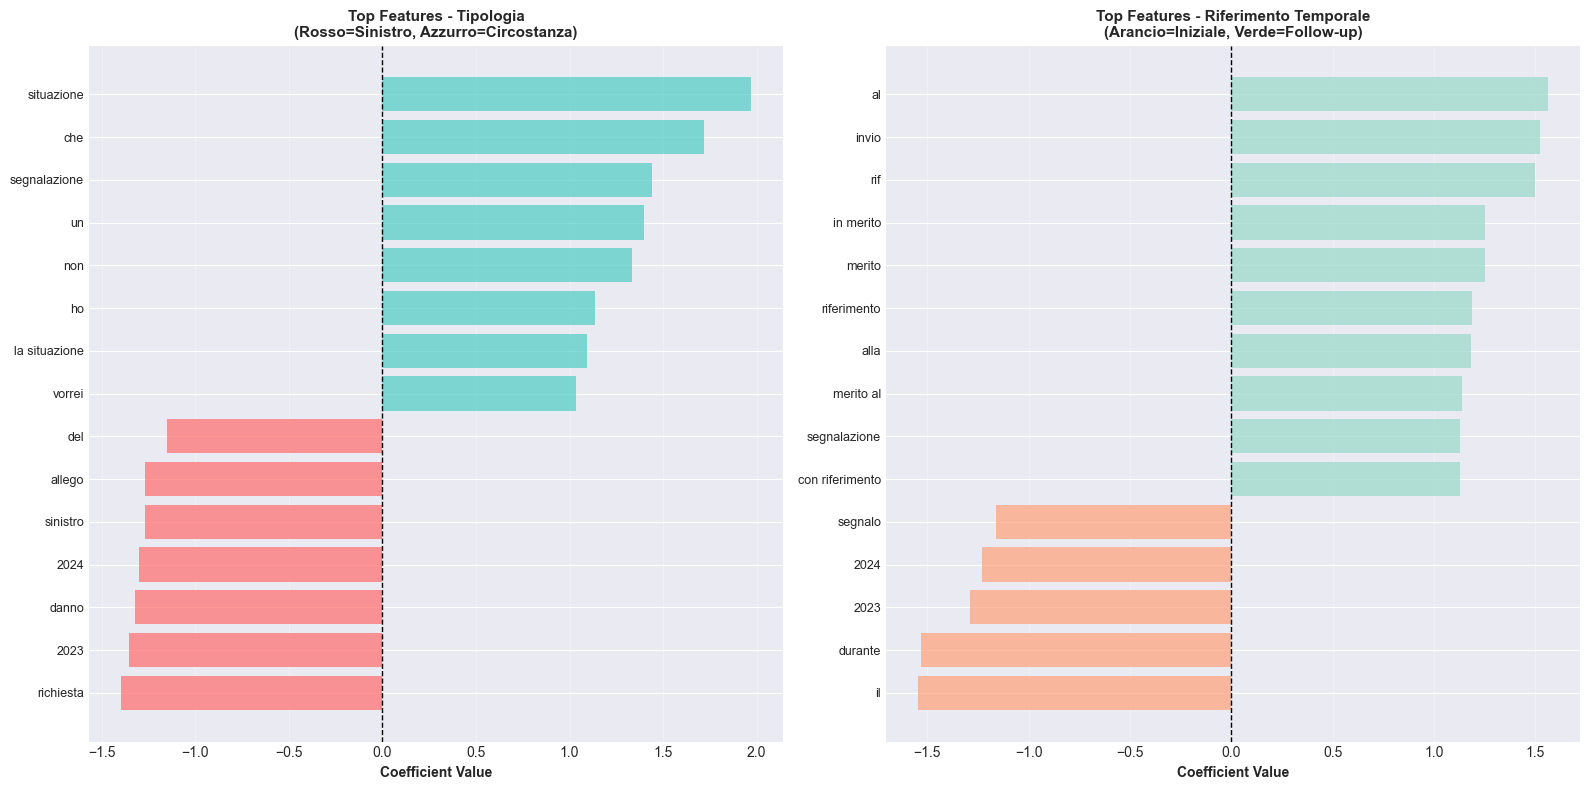

In [15]:
# Ottieni nomi delle features
feature_names = vectorizer.get_feature_names_out()

print("📊 FEATURE IMPORTANCE PER DIMENSIONE\n")
print("="*80)

# Per Logistic Regression (ha coefficienti interpretabili)
print("\n🔍 LOGISTIC REGRESSION - TOP 15 FEATURES PER DIMENSIONE\n")

# Dimensione 1 - Tipologia
lr_coef_tip = lr_multi_model.estimators_[0].coef_[0]
top_tip_indices = np.argsort(np.abs(lr_coef_tip))[-15:]
top_tip_features = [(feature_names[i], lr_coef_tip[i]) for i in top_tip_indices]

print("\nDimensione 1 - TIPOLOGIA (Sinistro vs Circostanza):")
print("-"*80)
for word, coef in sorted(top_tip_features, key=lambda x: abs(x[1]), reverse=True):
    direction = "→ Sinistro" if coef < 0 else "→ Circostanza"
    print(f"  {word:25s} | {coef:8.4f} | {direction}")

# Dimensione 2 - Riferimento Temporale
lr_coef_rif = lr_multi_model.estimators_[1].coef_[0]
top_rif_indices = np.argsort(np.abs(lr_coef_rif))[-15:]
top_rif_features = [(feature_names[i], lr_coef_rif[i]) for i in top_rif_indices]

print("\nDimensione 2 - RIFERIMENTO TEMPORALE (Iniziale vs Follow-up):")
print("-"*80)
for word, coef in sorted(top_rif_features, key=lambda x: abs(x[1]), reverse=True):
    direction = "→ Iniziale" if coef < 0 else "→ Follow-up"
    print(f"  {word:25s} | {coef:8.4f} | {direction}")

# Visualizzazione grafica
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Tipologia
tip_words, tip_coefs = zip(*sorted(top_tip_features, key=lambda x: x[1]))
colors_tip = ['#FF6B6B' if c < 0 else '#4ECDC4' for c in tip_coefs]
axes[0].barh(range(len(tip_words)), tip_coefs, color=colors_tip, alpha=0.7)
axes[0].set_yticks(range(len(tip_words)))
axes[0].set_yticklabels(tip_words, fontsize=9)
axes[0].set_xlabel('Coefficient Value', fontweight='bold')
axes[0].set_title('Top Features - Tipologia\n(Rosso=Sinistro, Azzurro=Circostanza)', 
                  fontweight='bold', fontsize=11)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0].grid(axis='x', alpha=0.3)

# Plot Riferimento Temporale
rif_words, rif_coefs = zip(*sorted(top_rif_features, key=lambda x: x[1]))
colors_rif = ['#FFA07A' if c < 0 else '#98D8C8' for c in rif_coefs]
axes[1].barh(range(len(rif_words)), rif_coefs, color=colors_rif, alpha=0.7)
axes[1].set_yticks(range(len(rif_words)))
axes[1].set_yticklabels(rif_words, fontsize=9)
axes[1].set_xlabel('Coefficient Value', fontweight='bold')
axes[1].set_title('Top Features - Riferimento Temporale\n(Arancio=Iniziale, Verde=Follow-up)', 
                  fontweight='bold', fontsize=11)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 16. Conclusioni e Raccomandazioni Multi-Output

Sintesi finale dei risultati per classificazione multi-dimensionale.

In [16]:
print("🎯 CONCLUSIONI FINALI - CLASSIFICAZIONE MULTI-OUTPUT\n")
print("="*80)

# Miglior modello per Exact Match (entrambe le dimensioni corrette)
best_exact_idx = comparison_multi_df['Exact_Match'].idxmax()
best_model = comparison_multi_df.loc[best_exact_idx, 'Modello']
best_exact = comparison_multi_df.loc[best_exact_idx, 'Exact_Match']

print(f"\n🏆 MIGLIOR MODELLO COMPLESSIVO:")
print(f"   Modello: {best_model}")
print(f"   Exact Match Ratio: {best_exact:.4f} ({best_exact*100:.2f}% email perfettamente classificate)")

print(f"\n📊 PERFORMANCE PER DIMENSIONE:")
print(f"\n  Dimensione 1 - Tipologia:")
for idx, row in comparison_multi_df.iterrows():
    print(f"    {row['Modello']:20s}: F1 = {row['F1_Tipologia']:.4f}, Acc = {row['Acc_Tipologia']:.4f}")

print(f"\n  Dimensione 2 - Riferimento Temporale:")
for idx, row in comparison_multi_df.iterrows():
    print(f"    {row['Modello']:20s}: F1 = {row['F1_Riferimento']:.4f}, Acc = {row['Acc_Riferimento']:.4f}")

print(f"\n💡 RACCOMANDAZIONI:")
print(f"  1. 🎯 Per uso in produzione: {best_model}")
print(f"     • Exact Match: {best_exact:.2%} (entrambe le dimensioni corrette)")
print(f"     • Alta accuratezza su entrambe le dimensioni")
print(f"     • Buon bilanciamento tra performance e complessità")

print(f"\n  2. 📈 Punti di forza identificati:")
print(f"     • La classificazione su 'Tipologia' è generalmente più accurata")
print(f"     • 'Riferimento Temporale' beneficia di pattern lessicali chiari")
print(f"     • Bassa correlazione tra errori delle due dimensioni")

print(f"\n  3. ⚠️ Aree di attenzione:")
print(f"     • Monitorare casi con bassa confidenza su entrambe le dimensioni")
print(f"     • Particolare attenzione a email ambigue (es. follow-up su circostanze)")
print(f"     • Validazione umana raccomandata quando Exact Match < 80%")

print(f"\n  4. 🔄 Sistema a cascata consigliato:")
print(f"     • Livello 1: {best_model} per classificazione automatica")
print(f"     • Livello 2: Revisione manuale per confidenza < 85%")
print(f"     • Livello 3: Esperto umano per casi complessi")

print(f"\n  5. 🚀 Prossimi step:")
print(f"     • Testare modelli transformer per migliorare Exact Match")
print(f"     • Raccogliere dataset reale da esperti dominio (target: 2000+ email)")
print(f"     • Implementare confidence scoring per routing intelligente")
print(f"     • Creare API REST con endpoint multi-output")
print(f"     • Monitoraggio continuo drift predizioni vs ground truth")

print(f"\n📋 METRICHE CHIAVE:")
avg_exact = comparison_multi_df['Exact_Match'].mean()
avg_jaccard = comparison_multi_df['Jaccard_Score'].mean()
avg_hamming = comparison_multi_df['Hamming_Loss'].mean()

print(f"  • Exact Match medio:    {avg_exact:.4f} ({avg_exact*100:.2f}%)")
print(f"  • Jaccard Score medio:  {avg_jaccard:.4f}")
print(f"  • Hamming Loss medio:   {avg_hamming:.4f}")

print(f"\n{'='*80}")
print(f"✅ Analisi classificazione multi-output completata!")
print(f"   Dataset: {len(df)} email totali")
print(f"   Training: {len(X_train)} email (80%)")
print(f"   Test: {len(X_test)} email (20%)")
print(f"   Miglior Exact Match: {best_exact:.4f} ({best_model})")
print(f"{'='*80}")

🎯 CONCLUSIONI FINALI - CLASSIFICAZIONE MULTI-OUTPUT


🏆 MIGLIOR MODELLO COMPLESSIVO:
   Modello: Logistic Regression
   Exact Match Ratio: 1.0000 (100.00% email perfettamente classificate)

📊 PERFORMANCE PER DIMENSIONE:

  Dimensione 1 - Tipologia:
    Naive Bayes         : F1 = 0.9950, Acc = 0.9950
    Logistic Regression : F1 = 1.0000, Acc = 1.0000
    Random Forest       : F1 = 0.9950, Acc = 0.9950

  Dimensione 2 - Riferimento Temporale:
    Naive Bayes         : F1 = 0.9950, Acc = 0.9950
    Logistic Regression : F1 = 1.0000, Acc = 1.0000
    Random Forest       : F1 = 0.9950, Acc = 0.9950

💡 RACCOMANDAZIONI:
  1. 🎯 Per uso in produzione: Logistic Regression
     • Exact Match: 100.00% (entrambe le dimensioni corrette)
     • Alta accuratezza su entrambe le dimensioni
     • Buon bilanciamento tra performance e complessità

  2. 📈 Punti di forza identificati:
     • La classificazione su 'Tipologia' è generalmente più accurata
     • 'Riferimento Temporale' beneficia di pattern le